# MLP

In [1]:
import numpy as np
import pandas as pd

import random
random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

import torch
torch.random.seed = 42
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
!cat ../data/wines_classification/winequality.names

In [3]:
!head ../data/wines_classification/winequality-red.csv

"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.4;0.66;0;1.8;0.075;13;40;0.9978;3.51;0.56;9.4;5
7.9;0.6;0.06;1.6;0.069;15;59;0.9964;3.3;0.46;9.4;5
7.3;0.65;0;1.2;0.065;15;21;0.9946;3.39;0.47;10;7
7.8;0.58;0.02;2;0.073;9;18;0.9968;3.36;0.57;9.5;7


In [4]:
df1 = pd.read_csv("../data/wines_classification/winequality-red.csv", sep=";") # skip feature names
df2 = pd.read_csv("../data/wines_classification/winequality-white.csv", sep=";")
df = pd.concat([df1, df2])

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
data = torch.tensor(df.sample(frac=1).values, dtype=torch.float)
data

tensor([[ 6.4000,  0.5300,  0.0900,  ...,  0.6700, 11.0000,  4.0000],
        [10.6000,  1.0200,  0.4300,  ...,  0.5700, 10.1000,  6.0000],
        [ 7.7000,  0.5700,  0.2100,  ...,  0.5400,  9.8000,  6.0000],
        ...,
        [ 7.1000,  0.3000,  0.4900,  ...,  0.5900, 10.2000,  5.0000],
        [ 7.0000,  0.1500,  0.3400,  ...,  0.6200, 10.8000,  5.0000],
        [ 9.0000,  0.4400,  0.4900,  ...,  0.5800,  9.2000,  5.0000]])

In [6]:
mu = np.mean(data.numpy(), 0)
std = (np.max(data.numpy(), 0) - np.min(data.numpy(), 0))

data_norm = torch.zeros_like(data)

for i, l in enumerate(data):
    for j, e in enumerate(l):
        data_norm[i, j] = (e - mu[j])/std[j]

In [7]:
X = data_norm[:,0:11]
y = data_norm[:, 11]

In [8]:
X_train = X[:4548, :]
y_train = y[:4548]

X_test = X[4548:, :]
y_test = y[4548:]

In [9]:
M, N = X_train.size()
print(M, N)

4548 11


In [10]:
class Net(nn.Module):
    
    def __init__(self, N, O):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N, O)
        self.fc2 = nn.Linear(O, 1)
        self.th = nn.Tanh()
        
    def forward(self, x):
        x = self.th(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net(N, 20)
print(net)

Net(
  (fc1): Linear(in_features=11, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
  (th): Tanh()
)


In [11]:
list(net.parameters())

[Parameter containing:
 tensor([[ 0.2189, -0.1755,  0.0630, -0.1073, -0.1161,  0.0383, -0.2945,  0.2995,
           0.2786,  0.0859,  0.0038],
         [ 0.1500, -0.2313, -0.0504,  0.1939, -0.1515,  0.2660, -0.1278,  0.0108,
          -0.2517,  0.1321, -0.1338],
         [ 0.2666,  0.2451,  0.2614,  0.0334,  0.0128,  0.0079,  0.1064,  0.0198,
          -0.1716,  0.0734,  0.0461],
         [ 0.2328,  0.1183, -0.0314,  0.1205,  0.1969, -0.0123,  0.1227,  0.0708,
           0.1711, -0.2780,  0.1247],
         [-0.1110, -0.2071,  0.2669,  0.1866,  0.0852,  0.2993,  0.1690,  0.0269,
           0.1727, -0.0385,  0.2097],
         [-0.1611,  0.2984,  0.2708,  0.0058,  0.0525,  0.2212,  0.1443,  0.1765,
           0.0303,  0.1652, -0.0789],
         [ 0.2201,  0.1991,  0.1280, -0.2758,  0.2439, -0.0991, -0.0997, -0.1370,
          -0.0451, -0.0347,  0.2470],
         [ 0.1509,  0.1718,  0.1991,  0.1553,  0.2390, -0.0044,  0.0140, -0.1348,
           0.0685, -0.2508, -0.0741],
         [ 0.0683

In [12]:
criterion = nn.MSELoss(reduction='mean')

In [13]:
def batch_train_step(net, X, y, alpha):
    net.zero_grad()
    output = net(X_train)
    loss = criterion(output, y_train)
    #loss = loss/N
    loss.backward()
    for f in net.parameters():
        f.data.sub_(f.grad.data * alpha)
    return loss.detach()

In [14]:
def batch_train(net, X, y, X_test, y_test, alpha=0.1, epsilon=0.001, gamma=100, max_iter=1000):
    mse_test_vec = []
    mse_train_vec = []
    mse_test = epsilon+1
    mse_min = 9999
    counter = 0
    iter = 0
    
    while (counter < gamma and mse_test > epsilon and iter < max_iter):
        output = net(X_test)
        mse_test = criterion(output, y_test).detach()
        mse_test_vec.append(mse_test)
        mse_train = batch_train_step(net, X, y, alpha)
        mse_train_vec.append(mse_train)

        
        if (mse_test >= mse_min):
            counter += 1
        else:
            mse_min = mse_test
            counter = 0
        
        iter += 1

    return (mse_train_vec, mse_test_vec)
        

In [15]:
epsilon = 0.01
alpha = 0.1
gamma = 50
max_iter = 1000

O: 10 alpha: 0.003
MSE_train: 0.021271659 MSE_test: 0.022532927


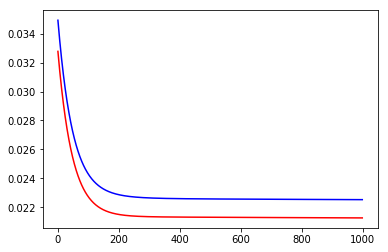

O: 10 alpha: 0.006
MSE_train: 0.021313874 MSE_test: 0.022604158


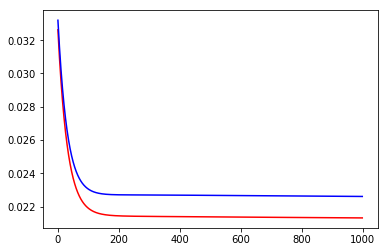

O: 10 alpha: 0.01
MSE_train: 0.021178806 MSE_test: 0.022435172


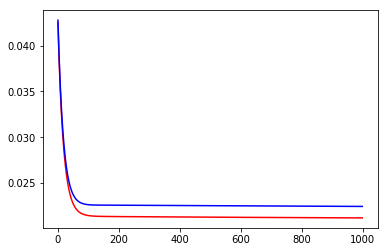

O: 10 alpha: 0.03
MSE_train: 0.021085275 MSE_test: 0.022350453


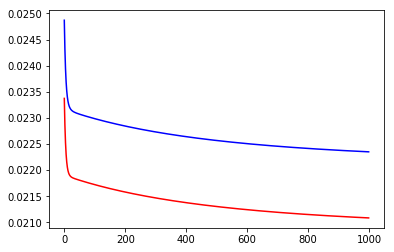

O: 10 alpha: 0.06
MSE_train: 0.02089675 MSE_test: 0.0221726


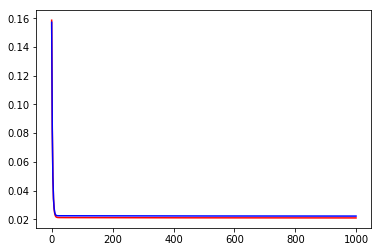

O: 30 alpha: 0.003
MSE_train: 0.02167334 MSE_test: 0.022979949


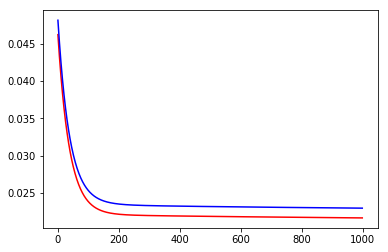

O: 30 alpha: 0.006
MSE_train: 0.021421362 MSE_test: 0.022706755


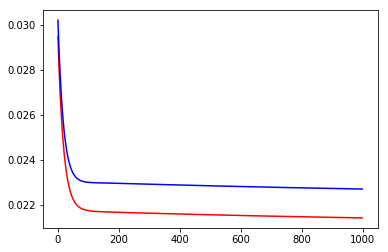

O: 30 alpha: 0.01
MSE_train: 0.021577554 MSE_test: 0.022831902


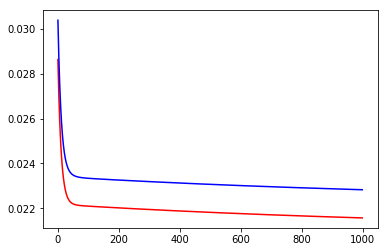

O: 30 alpha: 0.03
MSE_train: 0.020946056 MSE_test: 0.022205362


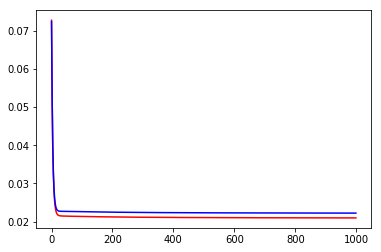

O: 30 alpha: 0.06
MSE_train: 0.020910995 MSE_test: 0.022176761


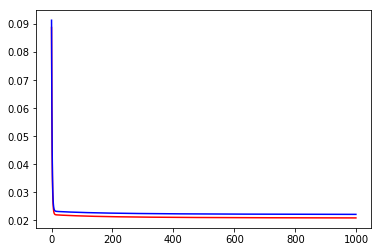

O: 80 alpha: 0.003
MSE_train: 0.021757156 MSE_test: 0.02309983


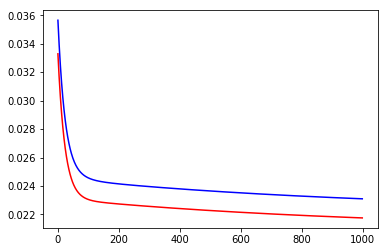

O: 80 alpha: 0.006
MSE_train: 0.021063475 MSE_test: 0.022360502


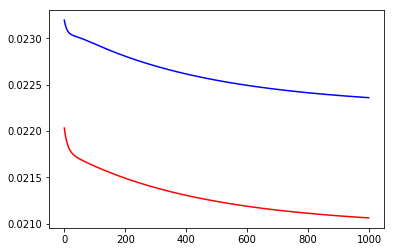

O: 80 alpha: 0.01
MSE_train: 0.021060072 MSE_test: 0.022334816


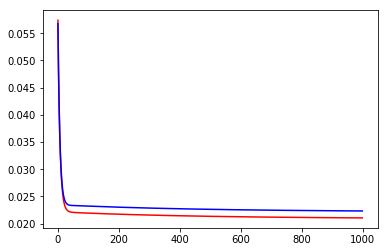

O: 80 alpha: 0.03
MSE_train: 0.020865116 MSE_test: 0.022128304


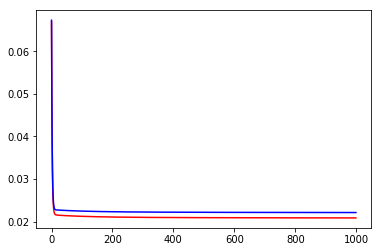

O: 80 alpha: 0.06
MSE_train: 0.020811103 MSE_test: 0.022082735


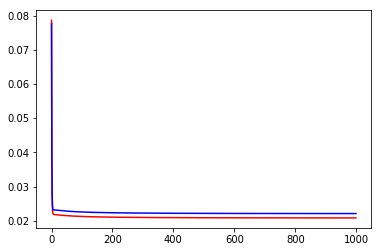

O: 150 alpha: 0.003
MSE_train: 0.021177886 MSE_test: 0.0224541


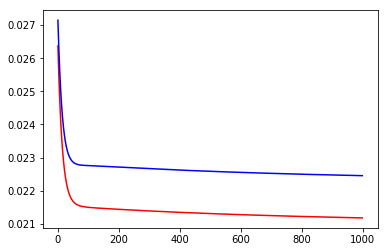

O: 150 alpha: 0.006
MSE_train: 0.021166725 MSE_test: 0.022431435


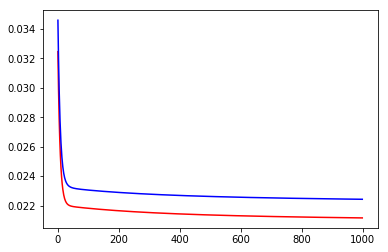

O: 150 alpha: 0.01
MSE_train: 0.02084545 MSE_test: 0.022112165


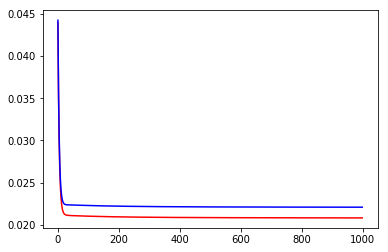

O: 150 alpha: 0.03
MSE_train: 0.020842416 MSE_test: 0.022114234


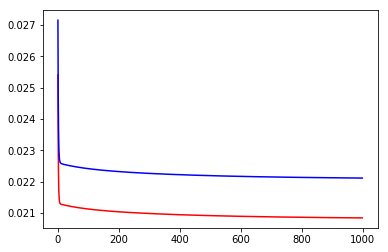

O: 150 alpha: 0.06
MSE_train: 0.020805001 MSE_test: 0.022074021


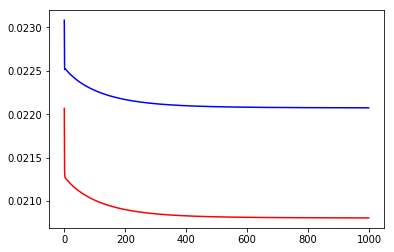

In [16]:
for O in [10, 30, 80, 150]:
    for alpha in [0.003, 0.006, 0.01, 0.03, 0.06]:
        print("O:", O, "alpha:", alpha)
        net = Net(N, O)
        
        (a, b) = batch_train(net, X_train, y_train, X_test, y_test,
                            alpha, epsilon, gamma, max_iter)
        
        print("MSE_train:", np.min(a), "MSE_test:", np.min(b))
        plt.plot(a, "r")
        plt.hold = True
        plt.plot(b, "b")
        plt.hold = False
        plt.show()